In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import io
import math

In [128]:
class Neuron:
    def __init__(self, potential, position, size, color='black', reset_potential=-1):
        self.position = position
        self.size = size
        self.color = color
        self.reset_potential = reset_potential
        self.potential = potential
        self.spiking = np.random.rand() > 0.5
        self.firing_rate = int(self.spiking) 
        self.nspikes = int(self.spiking)
        if self.spiking: self.potential = reset_potential

    def update_neuron_potential(self, new_potential):
        self.potential = new_potential
        
    def determine_neuron_color(self):
            if self.spiking: 
                color = 'green' 
                self.nspikes += 1
            else: 
                voltage_normalized = (self.potential + 1) / 2
                color_rgb = plt.cm.seismic(voltage_normalized)[:3]
                color = color_rgb
            return color
        
        

In [137]:
class Network:
    def __init__(self, N=60, tfr = 0.01, sandbox_size=(1000, 1000), size_range=(5, 50)):
        self.N = N
        self.neurons = []
        self.sandbox_size = sandbox_size
        self.size_range = size_range
        self.M = self.init_connectivity_matrix()
        self.V = []
        self.spikes = []
        self.neuron_sizes = []
        self.neuron_positions = []
        self.neuron_colors = []
        self.neuron_firing_rates = []
        self.tfr = tfr # target firing rate
        self.growth_coeff = 0.01
        

    def init_connectivity_matrix(self):
        M = np.random.rand(self.N, self.N)
        M = M / np.sum(M)
        M = M - np.transpose(M)
        np.fill_diagonal(M, 0)
        return M

    def init_neurons(self):
        sandbox_width, sandbox_height = self.sandbox_size
        for _ in range(self.N):
            potential = 2*np.random.rand()-1
            position = tuple(np.random.rand(2) * [sandbox_width, sandbox_height])
            size = np.random.uniform(self.size_range[0], self.size_range[1])
            color = 'black'
            self.neurons.append(Neuron(potential, position, size, color))
            
            self.V = [neuron.potential for neuron in self.neurons]
            self.spikes = [neuron.spiking for neuron in self.neurons]
            self.neuron_colors = [neuron.color for neuron in self.neurons]
            self.neuron_sizes = [neuron.size for neuron in self.neurons]
        
        
    def get_firing_rates(self, spiking_activity, window_size):
        
        firing_rates = np.zeros(self.N)

        for i in range(self.N):
            firing_rates[i] = np.sum(spiking_activity[i][-window_size:])
        firing_rates /= window_size

        return firing_rates

    def simulate(self, iterations, input_noise=170.5, leak=0.001, REST=-1, animate=True):
        spiking_activity = []
        V_list = []
        
        if animate:
            fig, ax = plt.subplots()
            frames = []
        
        for itn in range(iterations):
            # Updating V (potential) and determining which neurons spiked
            self.V = np.array(self.V) + input_noise * np.dot(self.M, self.spikes) + 0.1 * (np.random.rand(self.N) - 0.3) - leak * np.array(self.V)
            self.spikes = (self.V >= 1)
            self.V[self.spikes] = REST
            self.V[self.V < REST] = REST

            # Updating neuron object attributes for neurons in network
            for i in range(len(self.V)):
                self.neurons[i].spiking = self.spikes[i]
                self.neurons[i].potential = self.V[i]
                self.neurons[i].color = Neuron.determine_neuron_color(self.neurons[i]) # gets color and increments nspikes
                self.neurons[i].spiking = False  # Make sure to use boolean False instead of string 'False'
                
                self.neurons[i].firing_rate = self.neurons[i].nspikes / (itn+1)
                if self.neurons[i].firing_rate < self.tfr:
                    self.neurons[i].size *= (1+self.growth_coeff)
                else: 
                    self.neurons[i].size *= (1-self.growth_coeff)
                    
                    
                
                
            
            # Updating neuron_colors list    
            self.neuron_positions = [neuron.position for neuron in self.neurons]
            self.neuron_firing_rates = [neuron.firing_rate for neuron in self.neurons]
            
            #print(self.neuron_positions)

            # Updating global lists (keep track of all attributes for every iteration)
            V_list.append(self.V.copy())
            spiking_activity.append(self.spikes.copy())
            
            if animate:
                ax.clear()
                for neuron in self.neurons:
                    circle = plt.Circle(neuron.position, neuron.size, color=neuron.color, alpha=0.5)
                    ax.add_artist(circle)
                ax.set_xlim(0, self.sandbox_size[0])
                ax.set_ylim(0, self.sandbox_size[1])
                ax.set_aspect('equal')
                ax.axis('off')
                buf = io.BytesIO()
                fig.savefig(buf, format='png')
                buf.seek(0)
                frames.append(imageio.imread(buf))

        if animate:
            imageio.mimsave('animation.gif', frames, duration=0.1)
            

        return spiking_activity, V_list



    def draw(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        for neuron in self.neurons:
            circle = plt.Circle(neuron.position, neuron.size, color=neuron.color, alpha=0.5)
            ax.add_artist(circle)
        ax.set_xlim(0, self.sandbox_size[0])
        ax.set_ylim(0, self.sandbox_size[1])
        ax.set_aspect('equal')
        ax.axis('off')



    def plot_activity(self, spiking_activity, V_list):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(np.array(spiking_activity).T, aspect='auto', cmap='binary')
        plt.xlabel('Time')
        plt.ylabel('Neuron Index')
        plt.title('Neuron Firings Over Time')
        plt.subplot(1, 2, 2)
        plt.imshow(np.array(V_list).T, aspect='auto', cmap='seismic')
        plt.xlabel('Time')
        plt.ylabel('Neuron index')
        plt.title('Membrane Potential Over Time')
        plt.colorbar(label='Membrane Potential')
        plt.tight_layout()
        plt.show()

    def generate_animation(self, iterations, f_name='animation.gif', duration=1):
        fig, ax = plt.subplots()
        frames = []
        for _ in range(iterations):
            plt.clf()
            for neuron in self.neurons:
                circle = plt.Circle(neuron.position, neuron.size, color = neuron.color, alpha=0.5)
                ax.add_artist(circle)
            ax.set_xlim(0, self.sandbox_size[0])
            ax.set_ylim(0, self.sandbox_size[1])
            ax.set_aspect('equal')
            ax.axis('off')
            buf = io.BytesIO()
            fig.savefig(buf, format='png')
            buf.seek(0)
            frames.append(imageio.imread(buf))
        imageio.mimsave(f_name, frames, duration=duration)
        plt.close(fig)
        

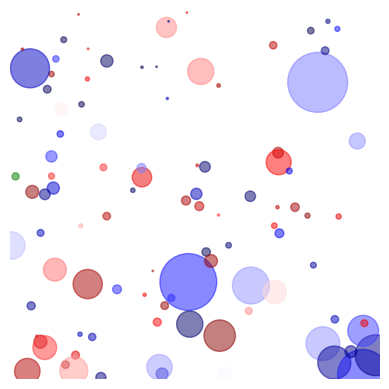

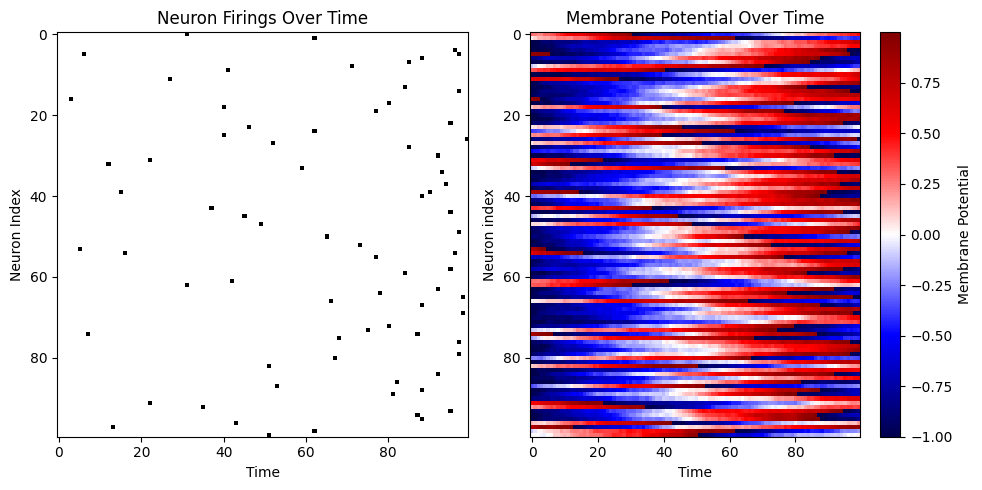

In [138]:
network = Network(N=5)
network.init_neurons()
#network.draw()
spiking_activity, V_list = network.simulate(iterations = 10, input_noise=50)
network.plot_activity(spiking_activity, V_list)

